In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

2024-11-14 12:36:32.821960: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load data
data = pd.read_csv("../data_cleaned/train_data_cleaned.csv", header=None, names=["tweet", "sentiment"])

# Split data
train_tweets, test_tweets, train_labels, test_labels = train_test_split(
    data["tweet"].to_numpy()[1:], data["sentiment"].to_numpy()[1:].astype(int), test_size=0.1, random_state=12
)

print("Train data shape:", train_tweets.shape)
print("Test data shape:", test_tweets.shape)

print(train_tweets[0], train_labels[0])

# Adjust labels from -1, 0, 1 to 0, 1, 2
train_labels += 1
test_labels += 1

# Convert tweets to embeddings
#model = SentenceTransformer("all-MiniLM-L6-v2")
model = SentenceTransformer("all-mpnet-base-v2")
train_embeddings = model.encode(train_tweets)
test_embeddings = model.encode(test_tweets)
print(len(train_embeddings[0]), len(train_embeddings))

Train data shape: (10006,)
Test data shape: (1112,)
Why Bill hiring attorneys Obama has Hillary take responsibility for Benghazi hiding behind her pantsuit GUTSYCALL 0
768 10006


In [15]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Build model with L2 regularization and dropout
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(len(train_embeddings[0]), )),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='relu'),
    Dense(3, activation='softmax')
])

nn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping and model checkpointing to keep the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=9, restore_best_weights=True)

# Train model
history = nn_model.fit(
    train_embeddings, train_labels,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)


Epoch 1/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4508 - loss: 1.0397 - val_accuracy: 0.5495 - val_loss: 0.9285
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5912 - loss: 0.9260 - val_accuracy: 0.6364 - val_loss: 0.8520
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6243 - loss: 0.8690 - val_accuracy: 0.6409 - val_loss: 0.8212
Epoch 4/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6415 - loss: 0.8422 - val_accuracy: 0.6374 - val_loss: 0.8185
Epoch 5/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6483 - loss: 0.8199 - val_accuracy: 0.6434 - val_loss: 0.8017
Epoch 6/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6688 - loss: 0.7830 - val_accuracy: 0.6374 - val_loss: 0.8049
Epoch 7/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6763 - loss: 0.7679 - val_accuracy: 0.6474 - val_loss: 0.7963
Epoch 8/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6866 - loss: 0.7453 - val_accuracy: 0.

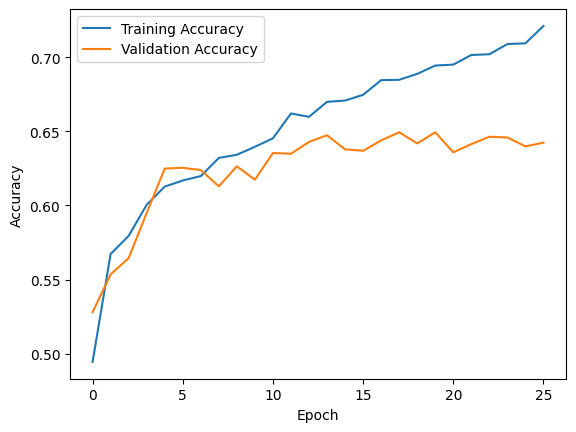

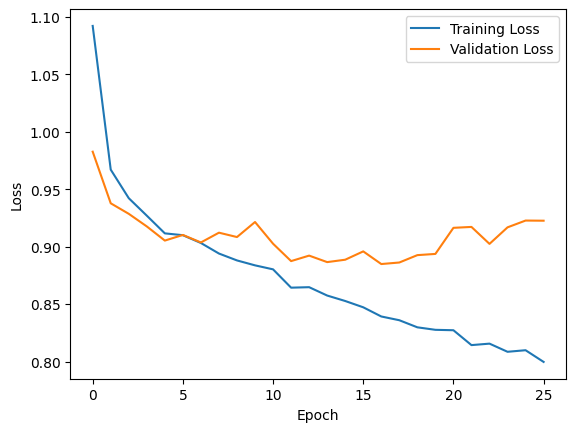

In [10]:
# Plot accuracy and loss
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [11]:
# Test accuracy
test_loss, test_accuracy = nn_model.evaluate(test_embeddings, test_labels)
print("Test Accuracy:", test_accuracy)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6553 - loss: 0.8851 
Test Accuracy: 0.6618704795837402


In [16]:
from sklearn.metrics import classification_report

# Predict the labels for the test set
test_predictions = nn_model.predict(test_embeddings).argmax(axis=1)

# Print the classification report
print(classification_report(test_labels, test_predictions, target_names=['Negative', 'Neutral', 'Positive']))

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

    Negative       0.67      0.81      0.73       482
     Neutral       0.60      0.49      0.54       366
    Positive       0.65      0.58      0.61       264

    accuracy                           0.65      1112
   macro avg       0.64      0.62      0.63      1112
weighted avg       0.64      0.65      0.64      1112

